# Analisis Pembatalan Pemesanan Hotel

Notebook ini bertujuan untuk menganalisis faktor-faktor yang berkaitan dengan
tingginya tingkat pembatalan pemesanan hotel.
Analisis difokuskan pada variabel yang merepresentasikan perilaku pelanggan
dan dapat ditindaklanjuti oleh manajemen hotel, yaitu:

- Jarak waktu pemesanan (*lead time*)
- *Market segment*
- Harga kamar (*Average Daily Rate / ADR*)

Pemilihan variabel ini dilakukan secara terfokus untuk menghasilkan insight
yang relevan dan bermakna secara bisnis.

Hasil analisis digunakan sebagai dasar penyusunan insight dan rekomendasi bisnis
berbasis data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    palette="deep",
    font_scale=1.0
)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [2]:
# Load data
df = pd.read_csv("hotels.csv")

df.shape

(119390, 32)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
# Tampilkan 5 baris pertama dari DataFrame
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Preparation

Tahap ini dilakukan untuk memastikan data berada dalam kondisi yang layak
untuk dianalisis. Beberapa langkah utama yang dilakukan meliputi penghapusan
nilai tidak valid, penanganan *outlier* ekstrem, serta penyesuaian variabel
yang digunakan dalam analisis.

In [5]:
# Hapus ADR tidak valid
df = df[df["adr"] > 0].copy()

# Hapus market segment undefined
df = df[df["market_segment"] != "Undefined"].copy()

df.shape

(117428, 32)

## Pengaruh Lead Time terhadap Pembatalan

Pada bagian ini, dilakukan analisis untuk memahami hubungan antara jarak waktu
pemesanan (*lead time*) dan tingkat pembatalan reservasi hotel.
Analisis ini penting untuk mengidentifikasi risiko pembatalan pada pemesanan
yang dilakukan jauh hari sebelum tanggal kedatangan.

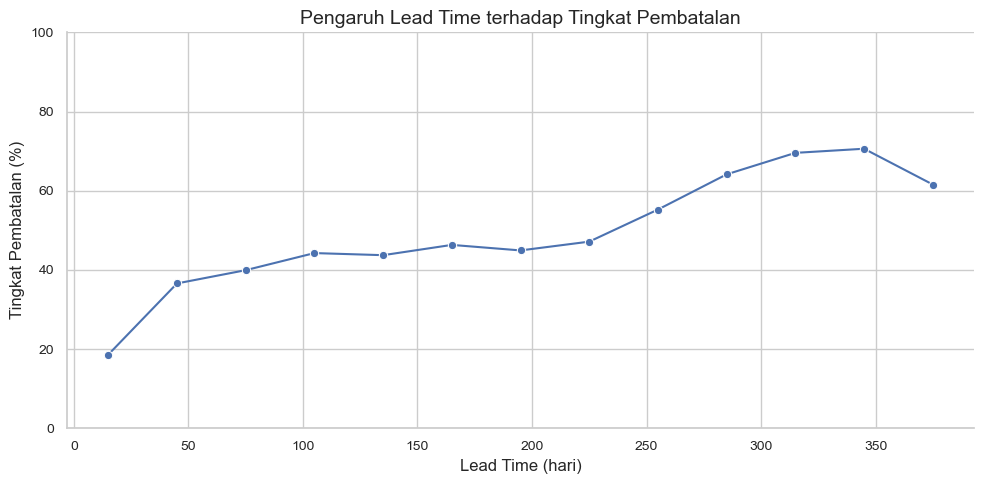

In [7]:
# Filter lead time ekstrem
df_lt = df[df["lead_time"] <= 365].copy()

# Bin lead time (per 30 hari)
bins = range(0, 391, 30)
df_lt["lead_time_bin"] = pd.cut(df_lt["lead_time"], bins=bins, right=False)

cancel_rate_lt = (
    df_lt
    .groupby("lead_time_bin", observed=True)
    .agg(
        cancel_rate=("is_canceled", "mean"),
        total_booking=("is_canceled", "count")
    )
    .reset_index()
)

cancel_rate_lt["cancel_rate_pct"] = cancel_rate_lt["cancel_rate"] * 100
cancel_rate_lt["lead_time_mid"] = cancel_rate_lt["lead_time_bin"].apply(
    lambda x: x.left + (x.right - x.left) / 2
)

cancel_rate_lt = cancel_rate_lt[cancel_rate_lt["total_booking"] >= 100]

plt.figure()
sns.lineplot(
    x=cancel_rate_lt["lead_time_mid"],
    y=cancel_rate_lt["cancel_rate_pct"],
    marker="o"
)

plt.title("Pengaruh Lead Time terhadap Tingkat Pembatalan")
plt.xlabel("Lead Time (hari)")
plt.ylabel("Tingkat Pembatalan (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig("images/lead_time_vs_cancellation.png", dpi=300)
plt.show()

Berdasarkan visualisasi di atas, terlihat bahwa tingkat pembatalan
meningkat seiring dengan bertambahnya lead time.
Hal ini menunjukkan bahwa pemesanan yang dilakukan jauh hari
memiliki tingkat komitmen pelanggan yang lebih rendah
dibandingkan pemesanan dengan lead time pendek.

## Pembatalan Berdasarkan Market Segment

Analisis ini bertujuan untuk memahami perbedaan tingkat pembatalan
berdasarkan segmen pasar (*market segment*).
Hasilnya dapat digunakan untuk menyusun kebijakan reservasi
yang berbeda sesuai dengan karakteristik masing-masing segmen.

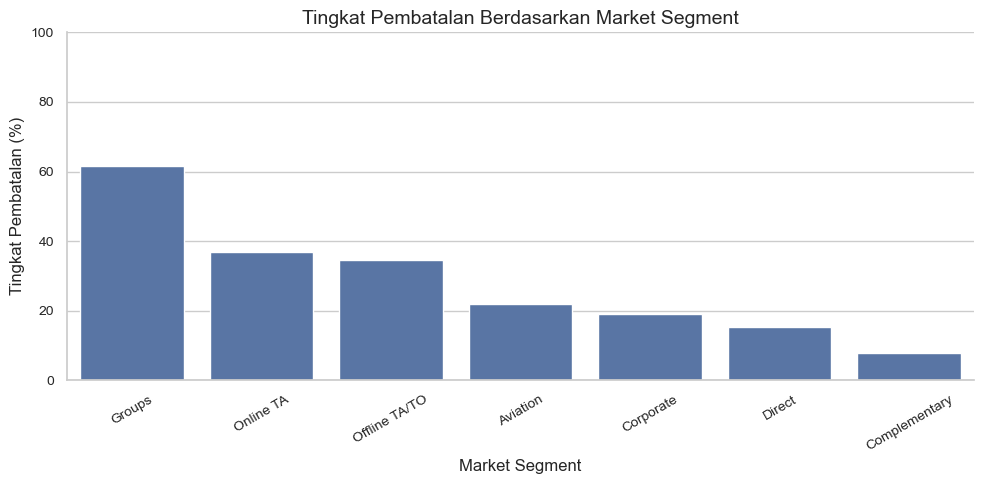

In [34]:
segment_cancel = (
    df
    .groupby("market_segment")
    .agg(
        cancel_rate=("is_canceled", "mean"),
        total_booking=("is_canceled", "count")
    )
    .reset_index()
)

segment_cancel["cancel_rate_pct"] = segment_cancel["cancel_rate"] * 100
segment_cancel = segment_cancel.sort_values("cancel_rate_pct", ascending=False)

plt.figure()
sns.barplot(
    data=segment_cancel,
    x="market_segment",
    y="cancel_rate_pct"
)

plt.title("Tingkat Pembatalan Berdasarkan Market Segment")
plt.xlabel("Market Segment")
plt.ylabel("Tingkat Pembatalan (%)")
plt.ylim(0, 100)
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig("images/market_segment_vs_cancellation.png", dpi=300)
plt.show()

Hasil analisis menunjukkan bahwa market segment **Groups** dan **Online TA**
memiliki tingkat pembatalan paling tinggi.
Temuan ini mengindikasikan bahwa segmen tersebut memerlukan
kebijakan reservasi dan pembatalan yang lebih ketat
dibandingkan segmen lainnya.

## Pengaruh Harga Kamar (ADR) terhadap Pembatalan

Pada bagian ini dianalisis hubungan antara harga kamar (*Average Daily Rate / ADR*)
dan tingkat pembatalan reservasi.
Analisis dilakukan menggunakan pendekatan *binning*
untuk menjaga stabilitas dan keterbacaan tren.

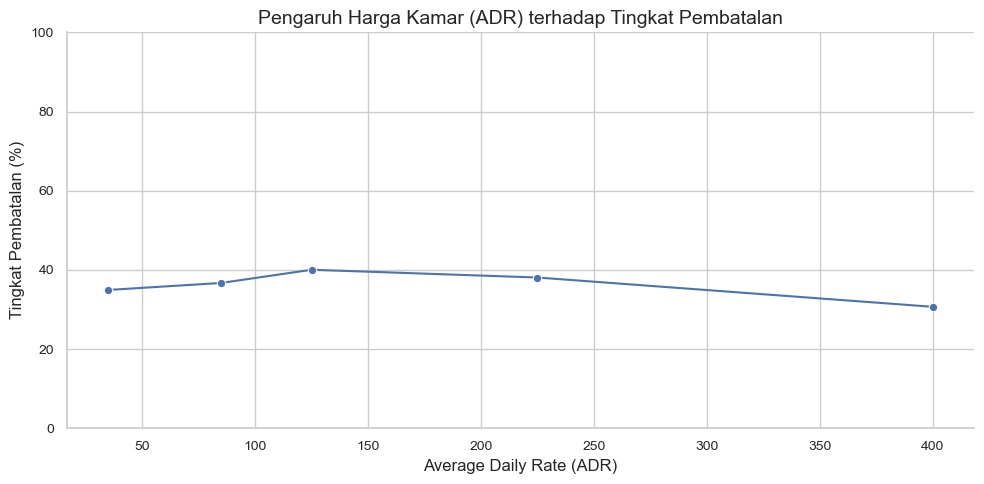

In [8]:
# Filter ADR ekstrem
df_adr = df[df["adr"] <= 500].copy()

adr_bins = [0, 70, 100, 150, 300, 500]
df_adr["adr_bin"] = pd.cut(df_adr["adr"], bins=adr_bins, right=False)

adr_cancel = (
    df_adr
    .groupby("adr_bin", observed=True)
    .agg(
        cancel_rate=("is_canceled", "mean"),
        total_booking=("is_canceled", "count")
    )
    .reset_index()
)

adr_cancel["cancel_rate_pct"] = adr_cancel["cancel_rate"] * 100
adr_cancel["adr_mid"] = adr_cancel["adr_bin"].apply(
    lambda x: x.left + (x.right - x.left) / 2
)

adr_cancel = adr_cancel[adr_cancel["total_booking"] >= 100]

plt.figure()
sns.lineplot(
    x=adr_cancel["adr_mid"],
    y=adr_cancel["cancel_rate_pct"],
    marker="o"
)

plt.title("Pengaruh Harga Kamar (ADR) terhadap Tingkat Pembatalan")
plt.xlabel("Average Daily Rate (ADR)")
plt.ylabel("Tingkat Pembatalan (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig("images/adr_vs_cancellation.png", dpi=300)
plt.show()

Visualisasi menunjukkan bahwa hubungan antara harga kamar dan pembatalan
bersifat tidak linear.
Tingkat pembatalan tertinggi terjadi pada rentang harga menengah,
sementara pemesanan dengan ADR yang sangat tinggi
menunjukkan tingkat pembatalan yang lebih rendah.
Hal ini mencerminkan perbedaan perilaku dan tingkat komitmen pelanggan
antar segmen harga.

## Kesimpulan

Berdasarkan analisis yang dilakukan, dapat disimpulkan bahwa pembatalan
pemesanan hotel dipengaruhi oleh beberapa faktor utama, yaitu:

- Lead time yang panjang meningkatkan risiko pembatalan
- Market segment tertentu, khususnya Groups dan Online TA, memiliki tingkat pembatalan lebih tinggi
- Hubungan antara harga kamar dan pembatalan bersifat tidak linear,
  dengan risiko tertinggi pada segmen harga menengah

Temuan ini menjadi dasar penyusunan rekomendasi kebijakan reservasi
yang lebih selektif dan berbasis risiko.